# Importation des bibliothéques utiles pour la suite

In [5]:
import matplotlib.pyplot as plt # Pour l'affichage des graphiques
import numpy as np
import pandas as pd

# Les modules pour les simulation
import ordinaryMC
import QMC
import MLMC

# Les modules pour les calculs et comparaisons
import calcul
import comparaison

# Importation des valeurs

In [6]:
alpha = 0.15
b = 1
sigma = 0.2
T = 1
r = 0.05
K = 4
k = 20
dt = 1/20
S_0 = 5 #le fixer à 1 si on veut obtenir les cheveux 
nb_samples = 100

# On conserve au maximum 1000, cependant pour certaines parties du projet à cause du temps de calcul max_sample pourra être réduit
max_sample = 1000

# Partie 1 : Monte Carlo Ordinaire

Le but de cette partie est de présenter la méthode monte carlo ordinaire avec :
- Le CIR ordinaire
- La simulation de Monte Carlo avec intervalles de confiance pour différentes valeurs de nb_samples
- La valeur du prix que nous allons fixer pour la suite "mean_pv_payoffs_cvg" pour la comparaison avec le MSE par la suite
- La valeur du CPU Time pour le nb_samples où l'on considére que le prix converge
- La valeur des MSE pour différents valeurs de nb_samples

# A) Test du CIR ordinaire

Dans cette section nous allons :
- tracer le CIR pour voir qualitativement sa trajectoire
- tracer un arbre avec un certain nombre de branches

In [5]:
S = ordinaryMC.CIR(alpha, b, sigma, T, k, S_0)
#S1 = CIR.CIR_new(alpha, b, sigma, T/k, T, S_0)

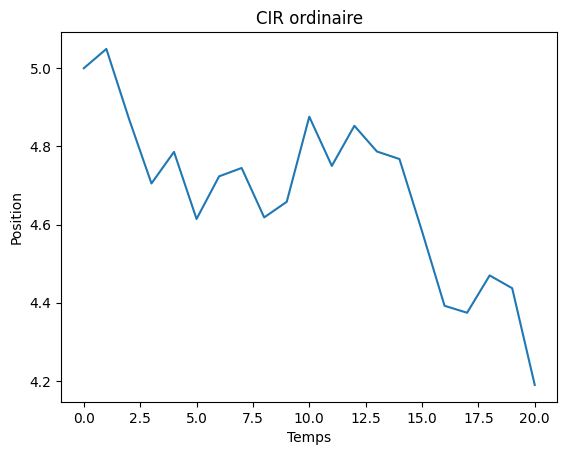

In [6]:
plt.plot(S)
#plt.plot(S1)
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('CIR ordinaire')
plt.show()

In [7]:
M = ordinaryMC.multiCIR(alpha, b, sigma, T, k, S_0, nb_samples)

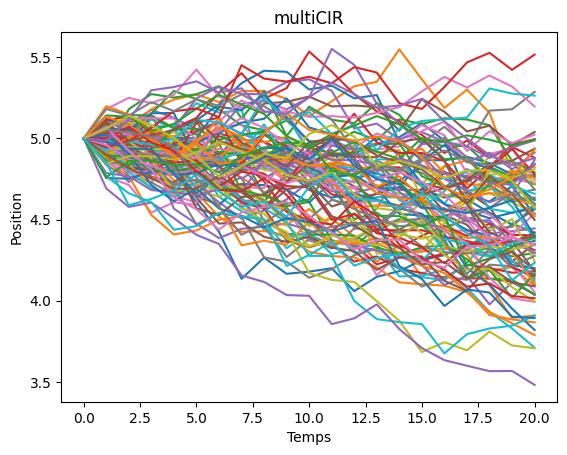

In [8]:
for i in range(nb_samples):
    plt.plot(M[i])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('multiCIR')
plt.show()

# B) Simulation de Monte Carlo Ordinaire

Dans cette section nous allons :
- Calculer le prix à partir de l'arbre que nous avons tracer précédemment
- Calculer les prix et intervalles de confiances pour différentes valeurs de nb_samples
- Nous allons considérer que le prix converge quand l'intervalle de confiance est inférieur à 0.001$, cependant pour des raisons de temps, nous allons choisir tol = 0.03$ de différence pour l'intervalle de confiance (la valeur de 0.001$ est accessible mais pour un nb_samples beaucoup trop grand)

In [9]:
calcul.pv_calc(M[3],r, T)

array([4.75614712, 4.66129354, 4.75682604, 4.7057349 , 4.72035208,
       4.59427259, 4.664185  , 4.58281431, 4.54912414, 4.45694357,
       4.29341761, 4.13562139, 4.03419608, 4.06453537, 3.99219313,
       3.96725103, 3.93957666, 4.01585521, 3.99591284, 3.9690547 ,
       3.97669561])

In [13]:
OMC = ordinaryMC.ordinary_mc_sim(nb_samples, k, S_0, T, r, sigma, K, alpha, b)

In [14]:
# Première estimation de la valeur C recherchée
np.mean(OMC)

0.6479191846062645

In [15]:
# On estime la valeur C pour différentes tailles d'échantillons de 10 en 10
ordinaryMC_price_esitmates, ordinaryMC_CIs = calcul.sim_iterator(max_sample, k, S_0, T, r, sigma, K, alpha, b, method='ordinary')

Price estimated at largest sample size with ordinary MC: 0.6752529572667797
CI length at largest sample size with ordinary MC: 0.02831826271874016


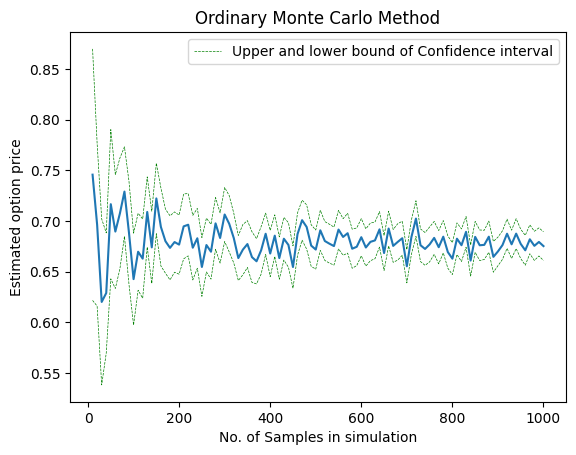

In [16]:
print("Price estimated at largest sample size with ordinary MC:", str(ordinaryMC_price_esitmates[-1]))
print("CI length at largest sample size with ordinary MC:", str(ordinaryMC_CIs[-1,1] - ordinaryMC_CIs[-1,0]))

#Ploting ordinary Monte Carlo method
x_axis1 = range(10, max_sample + 1, 10)
plt.plot(x_axis1, ordinaryMC_price_esitmates)
plt.plot(x_axis1, ordinaryMC_CIs[1:, 0], 'g--', lw=0.5, label='Upper and lower bound of Confidence interval')
plt.plot(x_axis1, ordinaryMC_CIs[1:, 1], 'g--', lw=0.5)
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated option price")
plt.title("Ordinary Monte Carlo Method")
plt.legend()
plt.show()


In [17]:
tol = 0.03
mc_threshold = comparaison.threshold_finder(ordinaryMC_CIs, tol)

86


In [18]:
if isinstance(mc_threshold, int) ==True :
    sample_convergent = mc_threshold * 10
    print("Le seuil que nous considérons comme être celui convergeznt sera donc par la suite :",sample_convergent)
else :
    print("Ce threshold n'est jamais atteint: il faut soit prendre un threshold plus grand ou un nombre de simulation maximale plus grand")


Le seuil que nous considérons comme être celui convergeznt sera donc par la suite : 860


# C) Comparaison Monte Carlo ordinaire pour des valeurs de nb_samples différetes

Dans cette section nous allons :
- Fixer le prix que l'on considère théorique 
- Trouver le CPU Time pour ce prix
- Calculer les MSE pour différentes valeurs de nb_samples

En réalité pour des problèmes de temps d'exécution (comme précédement) nous allons prendre une simulation pour un nb_sample = 100 000, ce qui aurait prit trop de temps à exécuter de 10 en 10.

In [20]:
present_payoffs_cvg = ordinaryMC.ordinary_mc_sim(100000,k, S_0, T, r, sigma, K, alpha, b)
mean_pv_payoffs_cvg = np.mean(present_payoffs_cvg)
print("La valeur du prix que nous allons fixer comme théorique est :",mean_pv_payoffs_cvg, "$")

La valeur du prix que nous allons fixer comme théorique est : 0.6789137256921417 $


In [22]:
CPU_sample = comparaison.CPU(sample_convergent,k, S_0, T, r, sigma, K, alpha, b, method='ordinary')
print("Le temps d'éxécution pour un nb_samples de",sample_convergent,"est:",CPU_sample)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Le temps d'éxécution pour un nb_samples de 860 est: 0.11604729999089614


In [23]:
max_sample_mse = 100
# Nous prenons 100 aussi pour des raisons de temps d'exécution, sinon vous pouvez mettre 1000 pour être cohérent avec le reste du projet
mse_values = comparaison.mse_comparaison(max_sample_mse, k, S_0, T, r, sigma, K, alpha, b, mean_pv_payoffs_cvg, method='ordinary')

10
20
30
40
50
60
70
80
90
100


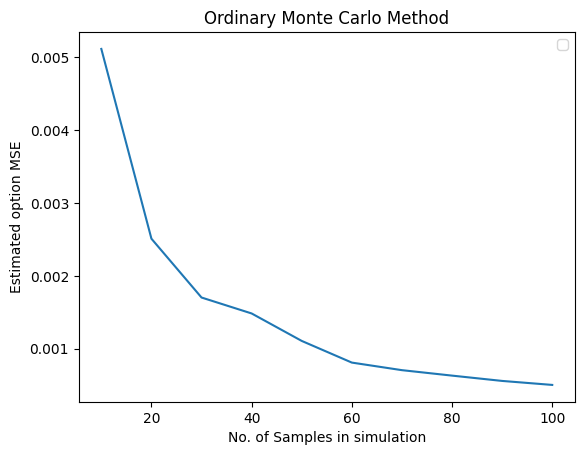

In [24]:
x_axis1 = range(10, max_sample_mse + 1, 10)
plt.plot(x_axis1, mse_values[0])
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated option MSE")
plt.title("Ordinary Monte Carlo Method")
plt.legend()
plt.show()

On obtient bien une courbe décroissante du MSE en la valeur de nb_samples.
Ce résultat est cohérent par rapport à ce que l'on pouvait d'attendre.

# Partie 2 : Quasi Monte Carlo

Le but de cette partie est de présenter la méthode quasi monte carlo et randomised quasi monte carlo avec :
- La trajectoire du CIR généré avec (randomised) Sobol pour une dimension d = 39
- La simulation du (randomised) quasi Monte Carlo avec intervalles de confiance pour différents nb_samples
- La valeur du CPU Time pour le randomised quasi monte carlo avec le nb_samples où l'on considére que ça converge
- La valeur des MSE pour différents nb_samples

# A) Tests Sobol generator et QMC

Dans cette section nous allons :
- Tracer le CIR du Sobol pour voir qualitativement sa trajectoire
- Tracer un arbre avec un certain nombre de branches
- Tracer les différentes valeurs de prix pour différents nb_samples
- Trouver le nb_samples à partir duquel l'intervalle de confiance est inférieur à tol = 0.03$

In [25]:
sobol = QMC.sobol_generator(nb_samples, k)
print(sobol, len(sobol), len(sobol[1,]))

[[0.5     0.75    0.25    ... 0.84375 0.34375 0.46875]
 [0.5     0.25    0.75    ... 0.21875 0.71875 0.09375]
 [0.5     0.75    0.25    ... 0.09375 0.59375 0.46875]
 ...
 [0.75    0.25    0.875   ... 0.53125 0.15625 0.65625]
 [0.75    0.25    0.375   ... 0.09375 0.21875 0.71875]
 [0.75    0.25    0.125   ... 0.78125 0.65625 0.15625]] 117 20


On obtient bien une suite de sobol qui respecte les propriétés recherchées

In [26]:
M = QMC.multiCIR_QMC(alpha, b, sigma, T, k, S_0, nb_samples)

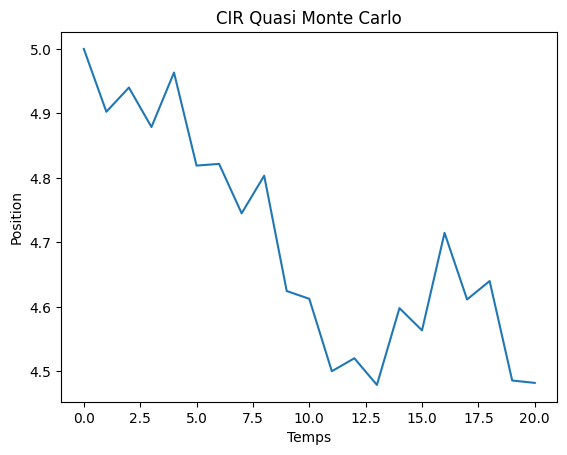

In [27]:
plt.plot(M[1])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('CIR Quasi Monte Carlo')
plt.show()

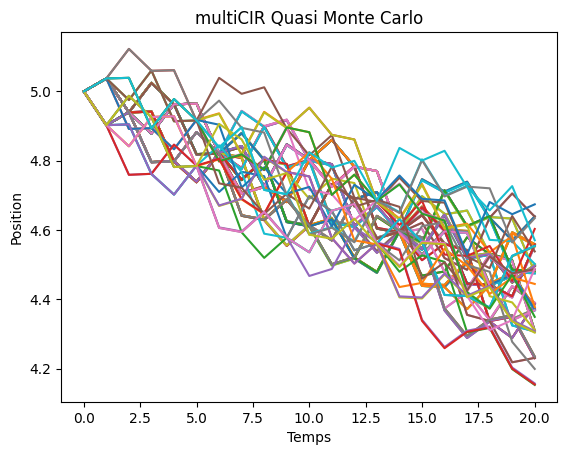

In [28]:
for i in range(nb_samples):
    plt.plot(M[i])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('multiCIR Quasi Monte Carlo')
plt.show()

In [29]:
calcul.pv_calc(M[3],r, T)

array([4.75614712, 4.66345079, 4.69914028, 4.56226408, 4.56486702,
       4.50807057, 4.58792692, 4.60631592, 4.49585464, 4.61115062,
       4.56896722, 4.55650063, 4.38662669, 4.44190474, 4.37079301,
       4.3235163 , 4.41775917, 4.2991677 , 4.31043676, 4.23279869,
       4.27786066])

In [30]:
OMC_QMC = QMC.QMC_mc_sim(nb_samples, k, S_0, T, r, sigma, K, alpha, b)
np.mean(OMC_QMC)

0.6729958803021122

In [31]:
sobol_price_esitmates, sobol_CIs = calcul.sim_iterator(max_sample, k, S_0, T, r, sigma, K, alpha, b, method="QMC")

In [32]:
print("Price estimated at largest sample size with Sobol sequence:", str(sobol_price_esitmates[-1]))
print("CI length at largest sample size with Sobol sequence:", str(sobol_CIs[-1,1] - sobol_CIs[-1,0]))

Price estimated at largest sample size with Sobol sequence: 0.672063980448986
CI length at largest sample size with Sobol sequence: 0.009965255969321296


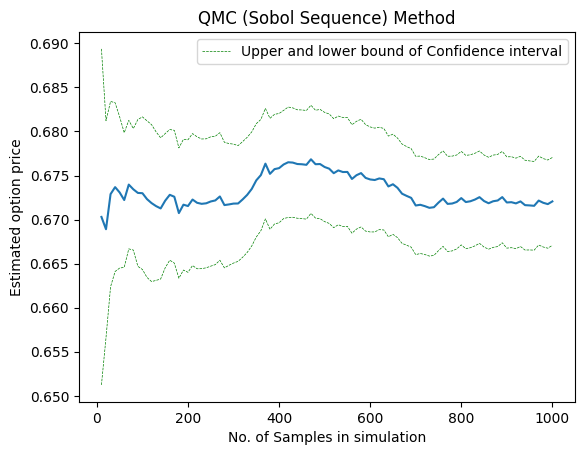

In [33]:
#Ploting quasi-Monte Carlo method using Sobol sequence
x_axis1 = range(10, max_sample + 1, 10)
plt.plot(x_axis1, sobol_price_esitmates)
plt.plot(x_axis1, sobol_CIs[1:, 0], 'g--', lw=0.5, label='Upper and lower bound of Confidence interval')
plt.plot(x_axis1, sobol_CIs[1:, 1], 'g--', lw=0.5)
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated option price")
plt.title("QMC (Sobol Sequence) Method")
plt.legend()
plt.show()

In [34]:
sobol_threshold = comparaison.threshold_finder(sobol_CIs, tol)

1


In [35]:
if isinstance(sobol_threshold, int) ==True :
    sample_convergent_QMC = sobol_threshold * 10
    print("Le seuil que nous considérons comme être celui convergeznt sera donc par la suite :",sample_convergent_QMC)
else :
    print("Ce threshold n'est jamais atteint: il faut soit prendre un threshold plus grand ou un nombre de simulation maximale plus grand")

Le seuil que nous considérons comme être celui convergeznt sera donc par la suite : 10


Nous pouvons constater que l'intervalle de confiance est beaucoup plus réduit que celui de la méthode ordinary. C'est normal, on peut le voir avec la formule du cours de la variance par rapport à la dimmension.

# B) QMC random

Dans cette section nous allons :
- Tracer un arbre du Randomised quasi monte carlo avec un certain nombre de branches

In [37]:
sobol_price_esitmates_random, sobol_CIs_random = calcul.sim_iterator(max_sample, k, S_0, T, r, sigma, K, alpha, b, method='QMC_random')


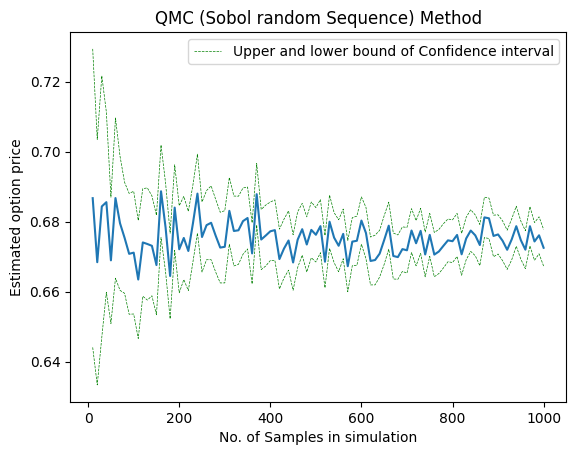

In [38]:
#Ploting quasi-Monte Carlo method using Sobol sequence
x_axis1 = range(10, max_sample + 1, 10)
plt.plot(x_axis1, sobol_price_esitmates_random)
plt.plot(x_axis1, sobol_CIs_random[1:, 0], 'g--', lw=0.5, label='Upper and lower bound of Confidence interval')
plt.plot(x_axis1, sobol_CIs_random[1:, 1], 'g--', lw=0.5)
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated option price")
plt.title("QMC (Sobol random Sequence) Method")
plt.legend()
plt.show()

In [39]:
sobol_randomised_threshold = comparaison.threshold_finder(sobol_CIs_random, tol)
if isinstance(sobol_randomised_threshold, int) ==True :
    sample_convergent_QMC_randomised = sobol_randomised_threshold * 10
    print("Le seuil que nous considérons comme être celui convergeznt sera donc par la suite :",sample_convergent_QMC_randomised)
else :
    print("Ce threshold n'est jamais atteint: il faut soit prendre un threshold plus grand ou un nombre de simulation maximale plus grand")

13
Le seuil que nous considérons comme être celui convergeznt sera donc par la suite : 130


# C) Comparaison QMC randomised

La comparaison est uniquement faites avec le QMC random car elle n'aurait pas de sens avec QMC étant une technique déterministe. Pour le prix que nous considérons comme convergent nous allons garder le même que celui de l'ordinary.

In [40]:
mean_pv_payoffs_cvg 
# On garde le même que pour l'ordinaire

0.6789137256921417

In [41]:
CPU_sample_QMC = comparaison.CPU(sample_convergent_QMC,k, S_0, T, r, sigma, K, alpha, b, method='QMC_random')
CPU_sample_QMC

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


0.006733599992003292

In [42]:
# max_sample_mse = 100
mse_values_QMC = comparaison.mse_comparaison(max_sample_mse, k, S_0, T, r, sigma, K, alpha, b, mean_pv_payoffs_cvg, method='QMC_random')


10
20
30
40
50
60
70
80
90
100


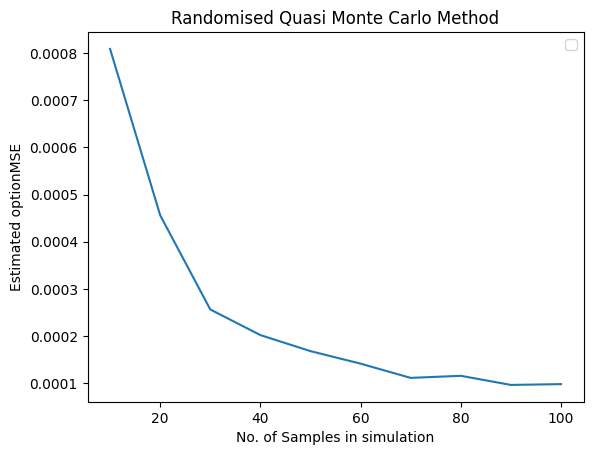

In [43]:
x_axis1 = range(10, max_sample_mse + 1, 10)
plt.plot(x_axis1, mse_values_QMC[0])
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated optionMSE")
plt.title("Randomised Quasi Monte Carlo Method")
plt.legend()
plt.show()

On obtient bien une courbe décroissante du MSE en la valeur de nb_samples.
Ce résultat est cohérent par rapport à ce que l'on pouvait d'attendre.

# Partie 3: Multi Level CIR

Le but de cette partie est de présenter la méthode multi level monte carlo avec :
- Le CIR multi level
- L'arbre monte carlo multi level

# A) Test du CIR multilevel

Dans cette section nous allons :
- tracer le CIR pour voir qualitativement sa trajectoire
- tracer un arbre avec un certain nombre de branches

In [16]:
L = 5
S = MLMC.CIR_ML(alpha, b, sigma, L, T, S_0)
S

(array([0.     , 0.03125, 0.0625 , 0.09375, 0.125  , 0.15625, 0.1875 ,
        0.21875, 0.25   , 0.28125, 0.3125 , 0.34375, 0.375  , 0.40625,
        0.4375 , 0.46875, 0.5    , 0.53125, 0.5625 , 0.59375, 0.625  ,
        0.65625, 0.6875 , 0.71875, 0.75   , 0.78125, 0.8125 , 0.84375,
        0.875  , 0.90625, 0.9375 , 0.96875, 1.     ]),
 array([5.        , 5.04283264, 5.02108787, 5.02146796, 5.14923146,
        5.11122351, 5.08342321, 5.14560331, 5.0597926 , 5.13909547,
        5.05650782, 5.15741374, 5.23906488, 5.0978488 , 5.04337218,
        5.10166306, 4.98331014, 4.97683434, 5.01323182, 5.09723624,
        5.16640493, 5.12882656, 4.98850661, 4.97354861, 4.83448016,
        4.59089199, 4.47723964, 4.25003809, 4.16812455, 4.22727756,
        4.40433742, 4.27606399, 4.31445064]))

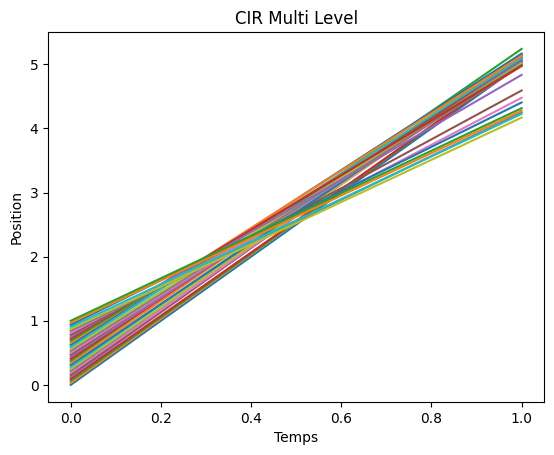

In [17]:
plt.plot(S)
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('CIR Multi Level')
plt.show()

In [19]:
M = MLMC.multiCIR_ML(alpha, b, sigma, L, T, S_0, nb_samples)
M

[[(array([0.     , 0.03125, 0.0625 , 0.09375, 0.125  , 0.15625, 0.1875 ,
          0.21875, 0.25   , 0.28125, 0.3125 , 0.34375, 0.375  , 0.40625,
          0.4375 , 0.46875, 0.5    , 0.53125, 0.5625 , 0.59375, 0.625  ,
          0.65625, 0.6875 , 0.71875, 0.75   , 0.78125, 0.8125 , 0.84375,
          0.875  , 0.90625, 0.9375 , 0.96875, 1.     ]),
   array([5.        , 5.056675  , 5.1510394 , 5.20018834, 5.24600774,
          5.16618937, 5.08747284, 5.11413595, 5.0536882 , 5.1492213 ,
          5.20850136, 5.10491262, 5.06290597, 5.00342073, 5.0181632 ,
          5.01611189, 4.89753392, 4.75102326, 4.56962332, 4.62676296,
          4.55887543, 4.56320303, 4.68869658, 4.55125979, 4.6474687 ,
          4.74424963, 4.7782751 , 4.69635309, 4.79787912, 4.74445134,
          4.8257448 , 4.90888463, 4.97697643])),
  ([0.0,
    0.0625,
    0.125,
    0.1875,
    0.25,
    0.3125,
    0.375,
    0.4375,
    0.5,
    0.5625,
    0.625,
    0.6875,
    0.75,
    0.8125,
    0.875,
    0.9375,
    

In [18]:
multiCIR=[]
M = MLMC.CIR_ML(alpha, b, sigma, 1/100, T, S_0)
multiCIR.append(M)


In [20]:
for j in range(3): 
    A = ([multiCIR[j][0][i] for i in range(0,len(multiCIR[j][0])+1,2)],[multiCIR[j][1][i] for i in range(0,len(multiCIR[j][0])+1,2)])
    multiCIR.append(A)

IndexError: list index out of range

In [83]:
multiCIR

[(array([0.        , 0.9930925 , 1.98618499]),
  array([5.        , 4.31625725, 4.38943822])),
 ([0.0, 1.9861849908740719], [5.0, 4.3894382176577444])]

In [80]:
for i in range(10):
    plt.plot(multiCIR[i][0],multiCIR[i][1])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('multiCIR')
plt.show()

NameError: name 'multiCIR' is not defined

In [ ]:
zap = CIR.CIR(alpha, b, sigma, T, k, S_0)
zap2 = CIR.CIR_ML(alpha, b, sigma, T, k, S_0,5)

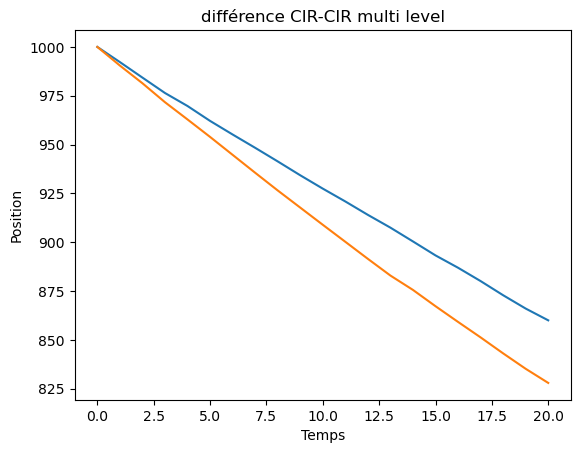

In [ ]:
plt.plot(zap)
plt.plot(zap2)
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('différence CIR-CIR multi level')
plt.show()

# B) Simulation de Monte Carlo Multilevel

Dans cette section nous allons :
- Calculer le prix à partir de l'arbre que nous avons tracer précédemment

Le ordinary tu fais n fois avec la même dicrétisation alors que le multi level tu fais n fois mais avec des discrétisations de plus en plus fines. Et en plus c'est "gratuit" car on utilise le même mouvement brownien.

In [84]:
test=MLMC.multiCIR_ML(alpha, b, sigma, 3, T, S_0, 3)

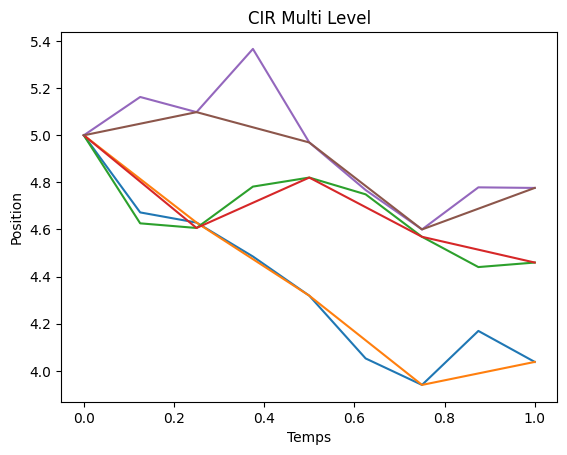

In [85]:
for i in range(3): #nb_sample
    plt.plot(test[i][0][0],test[i][0][1])
    plt.plot(test[i][1][0],test[i][1][1])


plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('CIR Multi Level')
plt.show()

In [86]:
MLMC.sim_MLMC(k, S_0, T, r, sigma, K, alpha, b) #return y_chap, L, N, variances, means

(0.6586991676452245,
 3,
 [91560, 41911, 30234, 18205],
 array([0.04529482, 0.00525481, 0.00197333, 0.00065609]),
 array([ 0.66515632, -0.00347413, -0.00180759, -0.00117543]))

In [11]:
max_sample = 100
MLMC_price_esitmates, MLMC_CIs = calcul.sim_iterator(10, k, S_0, T, r, sigma, K, alpha, b, method='MLMC')

In [13]:
MLMC_price_esitmates

array([0.])

Price estimated at largest sample size with MLMC: 0.0


ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

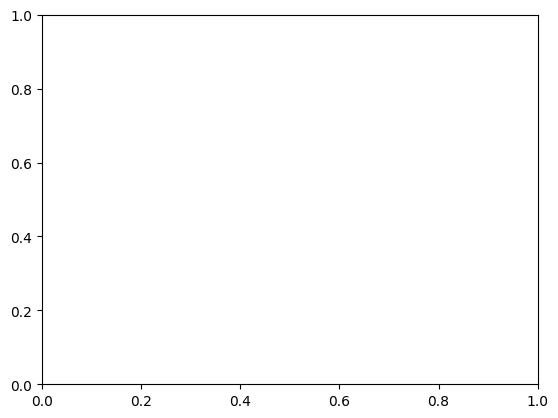

In [12]:
print("Price estimated at largest sample size with MLMC:", str(MLMC_price_esitmates[-1]))

#Ploting ordinary Monte Carlo method
x_axis1 = range(10, max_sample + 1, 10)
plt.plot(x_axis1, MLMC_price_esitmates)
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated option price")
plt.title("Multilevel Monte Carlo Method")
plt.legend()
plt.show()

# C) Comparaison Multi Level Monte Carlo

Dans cette section nous allons :
- Trouver le nombre nb_samples qu'il est nécessaire d'avoir pour réaliser la méthode multi level.
Ce nombre permettra par la suite de comparer les différentes méthodes avec le même nb_samples pour différents CPU Times et MSE

In [49]:
nb_samples_multi = np.sum(MLMC.ML_mc_sim(k, S_0, T, r, sigma, K, alpha, b)[2])
print("Le nombre de samples avec lequel nous allons comparer toutes les methodes est :", nb_samples_multi )

Le nombre de samples avec lequel nous allons comparer toutes les methodes est : 188669


# Partie 4 : Comparaison des intervalles de confiance, CPU Time optimal et MSE pour des nb_samples différents

# A) Intervalles de confiance

In [44]:
ordinary_CI_lengths = comparaison.CI_length_calc(ordinaryMC_CIs)
sobol_CI_lengths = comparaison.CI_length_calc(sobol_CIs)
sobol_CI_lengths_random = comparaison.CI_length_calc(sobol_CIs_random)

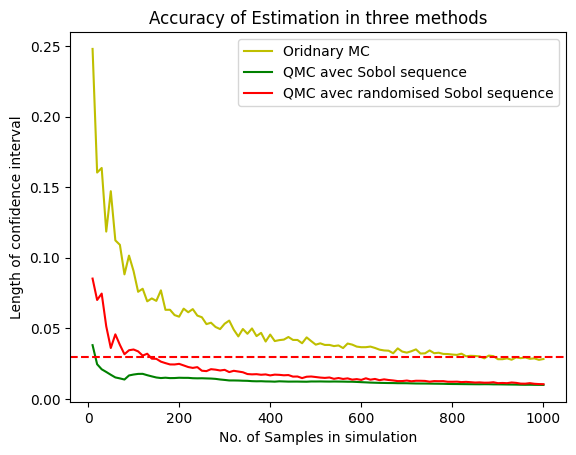

In [46]:
x_axis1 = range(10, max_sample + 1, 10)
plt.plot(x_axis1, ordinary_CI_lengths, 'y', label="Oridnary MC")
plt.plot(x_axis1, sobol_CI_lengths, 'g', label="QMC avec Sobol sequence")
plt.plot(x_axis1,sobol_CI_lengths_random, 'r', label="QMC avec randomised Sobol sequence")


tol = 0.03
plt.axhline(tol, ls='--', c='r')
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Length of confidence interval")
plt.title("Accuracy of Estimation in three methods")
plt.legend()
plt.show()

Comparaison des intervalles de confiance entre les différentes méthodes. La méthode QMC l'emporte sur les 3 autres et les méthode randomised QMC et QMC convergent.

# B) CPU Time

Nous allons comparer les CPU Times pour les différentes méthodes avec nb_samples = 188669. Au début nous voulions une boucle for de 100 valeurs, cependant vu le nombre très élevé de simulation nous allons en faire 3.

In [4]:
nb_samples_multi = 188669

In [6]:
CPU_sample_ordinary = comparaison.CPU(nb_samples_multi,k, S_0, T, r, sigma, K, alpha, b, method='ordinary')
CPU_sample_RQMC = comparaison.CPU(nb_samples_multi,k, S_0, T, r, sigma, K, alpha, b, method='QMC_random')
CPU_sample_MLMC = comparaison.CPU(nb_samples_multi,k, S_0, T, r, sigma, K, alpha, b, method='MLMC')

0
1
2
Le temps d'éxécution pour un nb_samples de 188669 est: 26.519047899986617
0
1
2
Le temps d'éxécution pour un nb_samples de 188669 est: 71.53722769999877
0
1
2
Le temps d'éxécution pour un nb_samples de 188669 est: 8.974359200045


In [12]:
print("Le temps d'éxécution pour ORDINARY pour un nb_samples de",nb_samples_multi,"est:",CPU_sample_ordinary)
print("Le temps d'éxécution pour RQMC pour un nb_samples de",nb_samples_multi,"est:",CPU_sample_RQMC)
print("Le temps d'éxécution pour MLMC pour un nb_samples de",nb_samples_multi,"est:",CPU_sample_MLMC)

NameError: name 'CPU_sample_ordinary' is not defined

# C) MSE

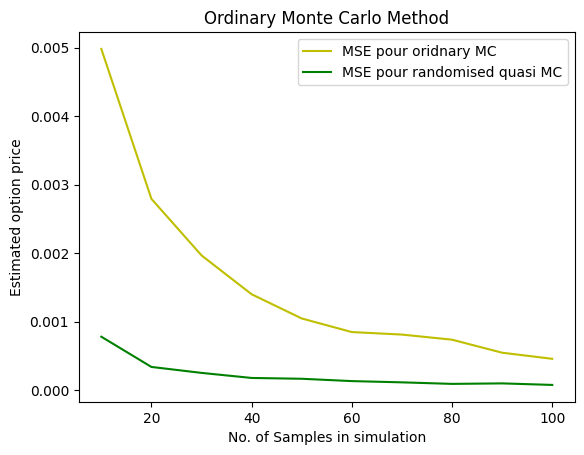

In [68]:
x_axis1 = range(10, max_sample_mse + 1, 10)
plt.plot(x_axis1, mse_values[0], 'y', label="MSE pour oridnary MC")
plt.plot(x_axis1, mse_values_QMC[0], 'g', label="MSE pour randomised quasi MC")
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated option price")
plt.title("Ordinary Monte Carlo Method")
plt.legend()
plt.show()

La méthode du randomised quasi monte carlo l'emporte.

Nous allons maintenant comparer les MSE des 3 méthodes pour nb_samples = 188669. Pour les mêmes raison les boucles for vont devoir être largement reduite du fait du fait de la valeur très élevée de nb_samples.

In [7]:
mean_pv_payoffs_cvg = 0.6781245997555464
nb_samples_multi = 188669

In [8]:
mse_ordinary_time = comparaison.mse_time(nb_samples_multi, k, S_0, T, r, sigma, K, alpha, b, mean_pv_payoffs_cvg, method='ordinary')
mse_RQMC_time = comparaison.mse_time(nb_samples_multi, k, S_0, T, r, sigma, K, alpha, b, mean_pv_payoffs_cvg, method='QMC_random')
mse_MLMC_time = comparaison.mse_time(0, k, S_0, T, r, sigma, K, alpha, b, mean_pv_payoffs_cvg, method='MLMC')

7.599747743971889e-06

In [11]:
print("Le mse pour ORDINARY pour un nb_samples de",nb_samples_multi,"est:", mse_ordinary_time)
print("Le mse pour RQMC pour un nb_samples de",nb_samples_multi,"est:",mse_RQMC_time)
print("Le mse pour MLMC pour un nb_samples de",nb_samples_multi,"est:",mse_MLMC_time)

Le mse pour ORDINARY pour un nb_samples de 188669 est: 1.1206664615632997e-06
Le mse pour RQMC pour un nb_samples de 188669 est: 7.599747743971889e-06
Le mse pour MLMC pour un nb_samples de 188669 est: 0.00031300780963052145
